In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import networkx as nx
import math
import osmnx as ox
from scipy.linalg import expm
from IPython.display import HTML
import scipy as sp
import os
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['font.family'] = 'CMU Serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 12
plt.rcParams['animation.embed_limit'] = 200971520.0

# Advection equation on oriented graphs

Given a finite oriented graph $G$, we consider the discrete advection equation
$$
\begin{split}
\dfrac{d}{dt}f_t(v)&=-[A_G\,f_t](v)\\
\Rightarrow f_t&=e^{-tA_G}f_0
\end{split}
$$
where $A_G$ represents a _discrete gradient operator_.

### Discrete Gradient

We consider the following advection operators, defined for a oriented graph $G\in\mathcal G$ and a function $f\in l^\infty$:
$$
\begin{split}
[A_1f](u)&=\sum_{v\in N^+(u)}\dfrac{f(v)-f(u)}{d_{uv}}\\
[A_2f](u)&=\sum_{v\in N^-(u)}\dfrac{f(u)-f(v)}{d_{vu}}\\ %=\left[\sum_{v\in N^-(u)}\dfrac{1}{d_{vu}}\right]f(u)-\sum_{v\in N^-(u)}\dfrac{f(v)}{d_{vu}}\\
[A_3f](u)&=\left[\sum_{w\in N^+(u)}\dfrac{1}{d_{uw}}\right]f(u)-\sum_{v\in N^-(u)}\dfrac{f(v)}{d_{vu}}\\
[A_4f](u)&=\left[\sum_{w\in N^+(u)}\dfrac{1}{\deg^+(u)\,d_{uw}}\right]f(u)-\sum_{v\in N^-(u)}\dfrac{f(v)}{\deg^+(v)\,d_{vu}}\\
[A_5f](u)&=\deg^+(u)\,s_u\,f(u)-\sum_{v\in N^-(u)}s_vf(v),
\end{split}
$$
where
$$
s_v=
\begin{cases}
\dfrac1{\displaystyle\sum_{w\in N^+(v)}d_{vw}} & \text{if $N^+(v)\ne\varnothing$}\\[6ex]
0& \text{otherwise}
\end{cases}
$$
Please note that $A_1$ and $A_2$ correspond, respectively, to a generalization of _forward_ and _backward Euler_, while $A_3$ and $A_4$ are modified versions of $A_2$.

In [2]:
def gradient(G, type=4):
    # G: oriented graph
    #       - also ok if G is directed, i.e., has edges with both directions
    #       - every edge should have a 'length' attribute
    # type: 1, 2, 3, 4 or 5
    if type == 1:
        # Forward Euler Gradient
        A1 = np.zeros((len(G), len(G)))
        for (u,v) in G.edges:
            A1[u,v] += 1
            A1[u,u] -= 1
        return A1
    elif type == 2:
        # Backward Euler Gradient,  satisfies Mass Transfer I 
        A2 = np.zeros((len(G), len(G)))
        for (v,u) in G.edges:  
            A2[u,u] += 1/G.edges[(v,u)]['length']
            A2[u,v] -= 1/G.edges[(v,u)]['length']
        return A2
    elif type == 3:
        # Satisfies Mass Transfer I & II
        A3 = np.zeros((len(G), len(G)))
        for (u,v) in G.edges:
            A3[v,u] -= 1/G.edges[(u,v)]['length']
            A3[u,u] += 1/G.edges[(u,v)]['length']
        return A3  
    elif type == 4:
        A4 = np.zeros((len(G), len(G)))
        # Satisfies all axioms
        for (u,v) in G.edges:
            A4[v,u] -= 1/G.edges[(u,v)]['length']/len(list(G.successors(u)))
            A4[u,u] += 1/G.edges[(u,v)]['length']/len(list(G.successors(u)))
        return A4
    elif type == 5:
        A5 = np.zeros((len(G), len(G)))
        # Satisfies all axioms but a different notion of isotropy 
        for (v,u) in G.edges:
            sd = sum([G.edges[(v,w)]['length'] for w in G.successors(v)])
            A5[u,v] -= 1/sd
            A5[v,v] += 1/sd
        return A5
    else:
        return None

### Parallel with discrete Markov Chain

**In the case in which all the edge lengths are unitary,** let $P$ be the (Markov) transition matrix of the graph $G$ in which every outcoming edge has equal probability. The evolution equation is
$$
f_{t+1} = P^Tf_t
$$
$$
\Rightarrow f_{t+1}-f_{t}=-(I-P^T)f_t
$$
If we interpret $f_{t+1}-f_t$ as the time derivative of $f_t$, then we get the discrete advection equation, with advection operator $I-P^T$. In this context (unitary edge lenghts), this corresponds exactly to $A_4$.

In [3]:
def markov(G):
    PT = nx.to_numpy_array(G)
    row_sums = PT.sum(axis=1)
    PT = np.transpose(PT / row_sums[:, np.newaxis])
    return PT

### Discrete Laplacian

We may also need a discretization of the Laplace operator.

In [4]:
def laplacian(G):
    # G: undirected graph
    L = np.zeros((len(G), len(G)))
    for u in G:
        for v in G.neighbors(u):
            d = G.edges[(u,v)]['length']
            L[u,u] += 1 / (d**2)
            L[u,v] -= 1 / (d**2)
    return L

## Some useful functions

In [5]:
def draw_graph(G, ax=None, positional=True, title=None, **kwargs):
    if positional:
        node_pos={u : (G.nodes[u]['x'], G.nodes[u]['y']) for u in G.nodes}
    else:
        node_pos=None

    kwargs.setdefault('with_labels', False)
    kwargs.setdefault('font_size', 16)
    kwargs.setdefault('node_size', 5)
    kwargs.setdefault('width', 1)

    if ax is None:
        ax=plt.gca()

    nx.draw(G, pos=node_pos, ax=ax, **kwargs)
    ax.set_aspect('equal')
    
    if title is not None:
        ax.set_title(title)

In [6]:
def relabel_nodes(G, return_labels=False):
    # Relabel nodes numerically (range(len(G)))
    labels = {}
    for i, u in enumerate(G.nodes):
        labels[u] = i
    G = nx.relabel_nodes(G, labels, copy=True)
    if return_labels:
        return G, labels
    else:
        return G

In [7]:
def bmatrix(a):
    # Returns a LaTeX bmatrix of the given numpy array a
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    for l in lines:
        elements = [e if not e.endswith('.') else e.rstrip('.') for e in l.split()]
        rv.append('  ' + ' & '.Goin(elements) + r'\\')
    rv +=  [r'\end{bmatrix}']
    return '\n'.Goin(rv)


## Theoretical examples

### Simple line graph (unitary length)

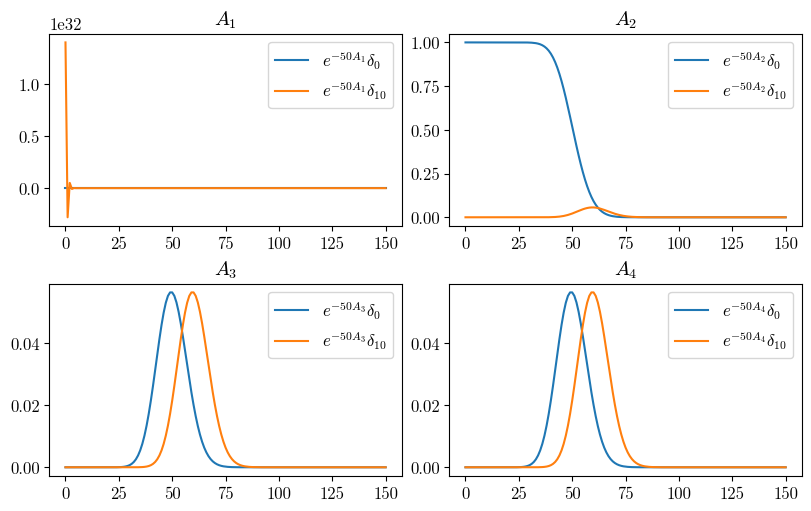

In [8]:
# Build the line graph
n = 150
G = nx.DiGraph()
G.add_node(0, x=0, y=0) 
for u in range(n):
    G.add_edge(u, (u+1), length=1)
    G.nodes[u+1]['x'] = u+1
    G.nodes[u+1]['y'] = u+1

# For any advection operator, plot the evolution of two initial data:
#   - mass concentrated on node 0 (in the boundary) 
#   - mass concentrated on node 10
fig, axs = plt.subplots(2, 2, figsize=(8, 5), layout='constrained')
for ax, type in zip(axs.flat, [1,2,3,4]):
    A = gradient(G, type=type)
    t = 50
    eA = expm(-t*A)
    for starting_mass in [0, 10]:
        f0 = np.zeros(len(G))
        f0[starting_mass] = 1
        ft = eA @ f0
        ax.plot(ft, label=f'$e^{{-{t}A_{{{type}}}}}\delta_{{{starting_mass}}}$')   
    ax.set_title(f'$A_{{{type}}}$')
    ax.legend()

### Cycle with shortcut (unitary length)

We consider a circular graph with the addition of an edge. We expect the mass to divide evenly when crossing this edge or not. We compare the solution of the advection equation (with different discretizations).

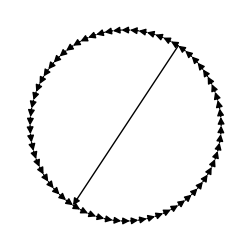

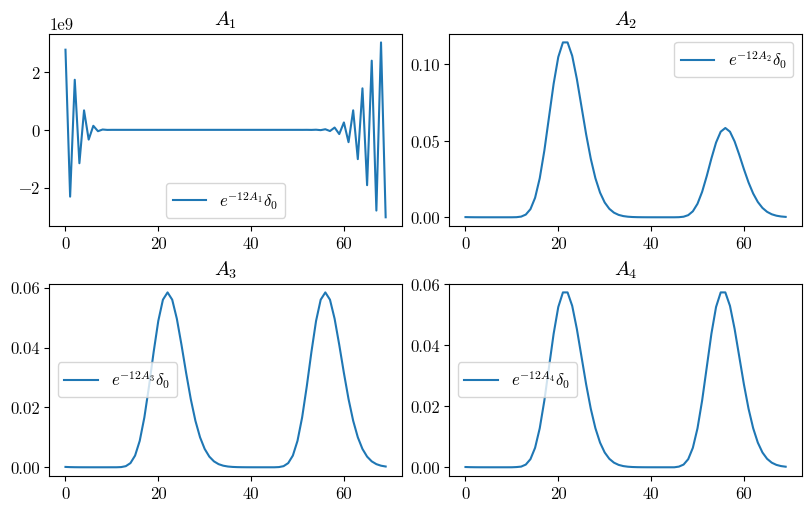

In [9]:
# Build the cycle graph...
n = 70
G = nx.DiGraph()
for u in range(n):
    G.add_edge(u, (u+1) % n, length=1)
    G.nodes[u]['x'] = math.cos(u*2*math.pi/n)
    G.nodes[u]['y'] = math.sin(u*2*math.pi/n)
    
# ... with a shortcut
G.add_edge(int(n/6), int(2*n/3), length=1)

plt.figure(figsize=(3,3))
draw_graph(G, node_size=0)

# Advection evolution
fig, axs = plt.subplots(2, 2, figsize=(8, 5), layout='constrained')
for ax, type in zip(axs.flat, [1,2,3,4]):
    A = gradient(G, type=type)
    t = 12
    eA = expm(-t*A)
    f0 = np.zeros(len(G))
    f0[starting_mass] = 1
    ft = eA @ f0
    ax.plot(ft, label=f'$e^{{-{t}A_{{{type}}}}}\delta_0$')
    ax.set_title(f'$A_{{{type}}}$')
    ax.legend()


### Limiting distribution (comparison with Markov limiting distribution)

**In the case in which all the edge lengths are unitary,** we observe that
$$
\lim_{n\to\infty} (P^T)^n f_0 = \lim_{t\to \infty} e^{-A_4t}f_0.
$$

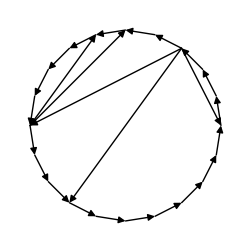

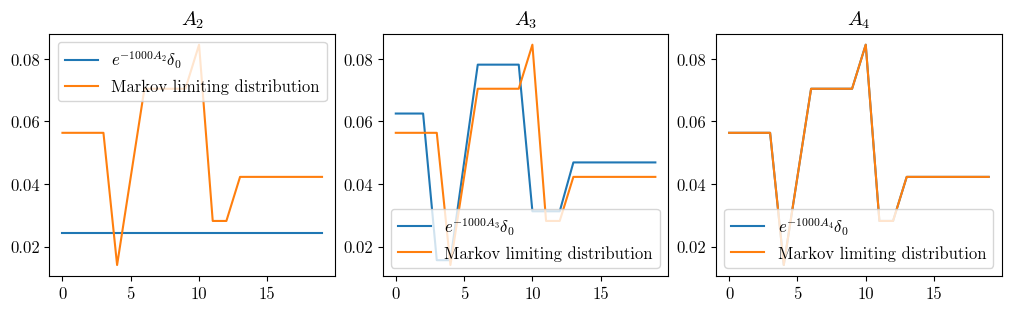

In [10]:
# Build the cycle graph...
n = 20
G = nx.DiGraph()
for u in range(n):
    G.add_edge(u, (u+1) % n, length=1)
    G.nodes[u]['x'] = math.cos(u*2*math.pi/n)
    G.nodes[u]['y'] = math.sin(u*2*math.pi/n)

# ... with many shortcuts
G.add_edge(int(n/6), int(2*n/3), length=1)
G.add_edge(int(n/6), int(n/2), length=1)
G.add_edge(int(n/6), int(0), length=1)
G.add_edge(int(n/2), int(n/3), length=1)
G.add_edge(int(n/2), int(n/4), length=1)

plt.figure(figsize=(3,3))
draw_graph(G, node_size=0)

# Markov evolution
PT = markov(G)
fm = np.zeros(len(G))
fm[0] = 1
for _ in range(1000):
    fm = PT @ fm

# Advection evolution
fig, axs = plt.subplots(1,3, figsize=(10, 3), layout='constrained')
for ax, type in zip(axs.flat, [2,3,4]):
    A = gradient(G, type=type)
    t = 1000
    eA = expm(-t*A)
    f0 = np.zeros(len(G))
    f0[starting_mass] = 1
    ft = eA @ f0
    ax.plot(ft, label=f'$e^{{-{t}A_{{{type}}}}}\delta_0$')
    ax.plot(fm, label='Markov limiting distribution')
    ax.set_title(f'$A_{{{type}}}$')
    ax.legend()



### Cycle graph with different edge lengths

We consider a linear graph where the first $20$ nodes have alternating lengths of $1$ and $2$. We observe spikes on nodes preceding longer edges (because the mass stays there longer). These spikes disappear when the mass moves onto edges with uniform length. **When estimating the amount of traffic by looking at nodes where there is a transient accumulation of mass, we must ensure that we are not mainly measuring nodes followed by longer edges. (The issue persists even with some diffusion added).** [See the example about Pisa's roads at the end.]

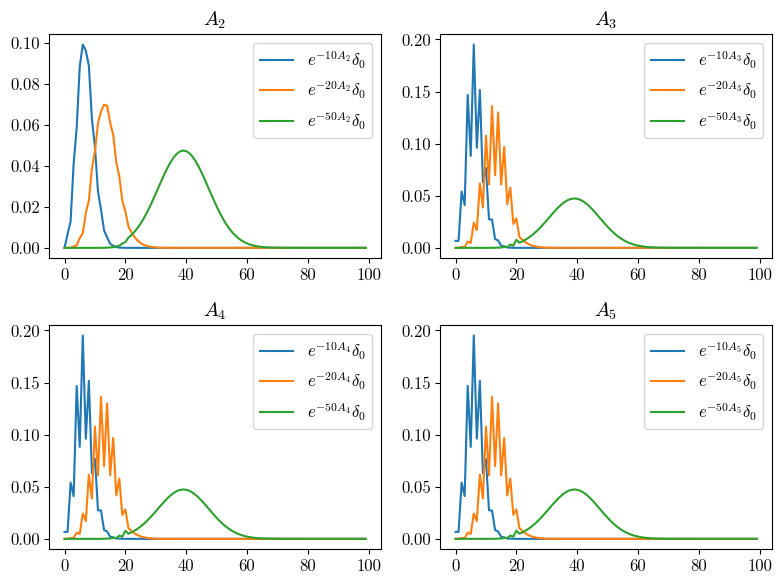

In [11]:
n = 100
G = nx.DiGraph()
for u in range(n):
    G.add_edge(u, (u+1) % n, length=2 if u % 2 == 0 and u<=20 else 1)

A = gradient(G, type=2)
f0 = np.zeros(len(G))
f0[0] = 1

# Advection evolution
fig, axs = plt.subplots(2,2, figsize=(8, 6), layout='constrained')
for ax, type in zip(axs.flat, [2, 3, 4, 5]):
    A = gradient(G, type=type)
    t = 1000
    eA = expm(-t*A)
    f0 = np.zeros(len(G))
    f0[0] = 1
    for t in [10, 20, 50]:
        ft  = expm(-t*A) @ f0
        ax.plot(ft, label=f'$e^{{-{t}A_{{{type}}}}}\delta_0$')
    ax.set_title(f'$A_{{{type}}}$')
    ax.legend()


ax.legend()
fig.tight_layout()

### Axiom of Advection II

We consider a cycle graph with $n=400$ nodes whose first $50$ edges have random lengths. We also add some (forward) edges to the graph.

Expected value of ft (with A2) = 298.7021229250183
Expected value of ft (with A3) = 299.9949465823178
Expected value of ft (with A4) = 149.9999999999999
Expected value of ft (with A5) = 150.0000000000002


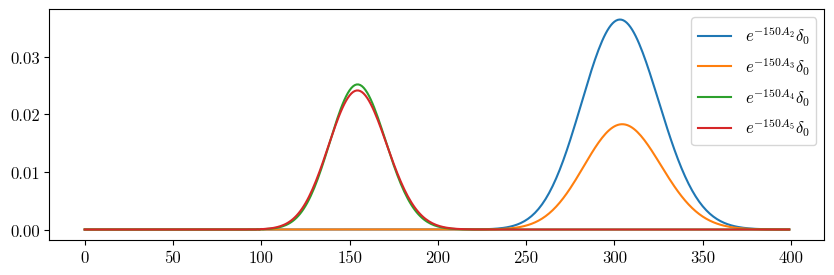

In [12]:
n = 400

np.random.seed(0)

G = nx.DiGraph()
G.add_node(0, x=0, y=0)
s = 0
for u in range(n):
    d = 2*np.random.rand() if u <= n/4 else 1
    G.add_edge(u, (u+1) % n, length=d)
    s += d
    if u < n-1:
        G.nodes[u+1]['x'] = s
        G.nodes[u+1]['y'] = 0

for i in range(0,len(G)-2):
    G.add_edge(i, i+2, length=G.nodes[i+2]['x']-G.nodes[i]['x'])

t = 100


# Advection evolution
plt.figure(figsize=(10, 3))
for type in [2,3,4,5]:
    A = gradient(G, type=type)
    t = 150
    eA = expm(-t*A)
    f0 = np.zeros(len(G))
    f0[0] = 1
    ft = eA @ f0
    plt.plot(ft, label=f'$e^{{-{t}A_{{{type}}}}}\delta_0$')
    expected_value = sum([G.nodes[u]['x']*ft[u] for u in G.nodes])/sum([ft[u] for u in G.nodes])
    print(f'Expected value of ft (with A{type}) = {expected_value}')

plt.legend()
plt.show()


### Tangent cycles

It is straightforward to verify that both the operators $A_3$ and $A_4$ satisfy the axiom of Advection I, while only $A_4$ also satisfies Advection II. Let us apply those operators to a graph which comprises two connected cycles, with an initial unitary mass located at the common node $0$. Since both cycles have a total length of $1$, we anticipate that the mass will peak at node $0$ whenever $t$ is an integer. However, for large $t$, we only observe this behavior with $A_4$, which satisfies the axiom of Advection II. With $A_3$, on the other hand, the mass flows along the two cycles without perfect synchronization, ultimately converging to a uniform distribution.

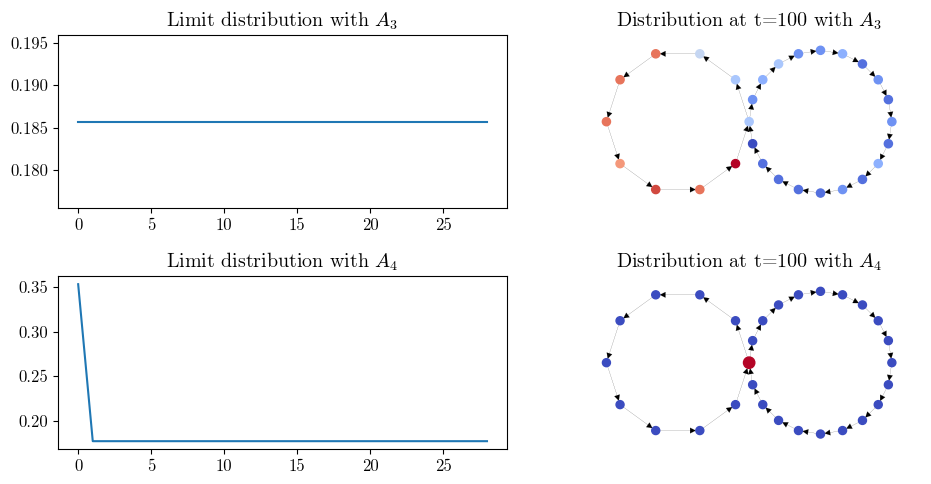

In [13]:
n=10
m=20

G = nx.DiGraph()
for u in range(n):
    G.add_edge(u, (u+1) % n, length=1/n)
    G.nodes[u]['x'] = -1+math.cos(u*2*math.pi/n)
    G.nodes[u]['y'] = math.sin(u*2*math.pi/n)

for u in range(m):
    G.add_edge(-u, -((u+1) % m), length=1/m)
    G.nodes[-u]['x'] = 1+math.cos(math.pi-u*2*math.pi/m)
    G.nodes[-u]['y'] = math.sin(math.pi-u*2*math.pi/m)

G = relabel_nodes(G)

fig, ax = plt.subplots(2, 2, figsize=(10,5))
for i, type in enumerate([3,4]):
    A = gradient(G, type=type)
    values, vectors = sp.sparse.linalg.eigs(-A, k=1, sigma=0)
    f_eig = np.ndarray.flatten(np.real(vectors))
    ax[i,0].plot(abs(f_eig))
    ax[i,0].set_title(f'Limit distribution with $A_{{{type}}}$')
    
    t = 100
    ft = np.zeros(len(G))
    ft[0] = 1
    ft  = expm(-t*A) @ ft
    draw_graph(G, ax=ax[i,1], node_color=ft, width=0.1, node_size=1000*ft, cmap='coolwarm')
    ax[i,1].set_title(f'Distribution at t={t} with $A_{{{type}}}$')

plt.tight_layout()

(-4, 0.0714285714309844)
(-3, 0.07142857142967379)
(-2, 0.07142857142615372)
(-1, 0.07142857142442033)
(0, 0.14285714285563522)
(1, 0.07142857142446221)
(2, 0.07142857142277886)
(3, 0.0714285714237484)
(4, 0.07142857142715717)
(5, 0.0714285714315849)
(6, 0.07142857143497791)
(7, 0.07142857143558612)
(8, 0.0714285714328433)


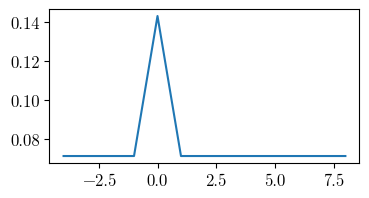

In [14]:
## Code for Figure 'f:advection_resonance_markov'

n=5
m=9

G = nx.DiGraph()
for u in range(n):
    G.add_edge(u, (u+1) % n, length=1/n)
    G.nodes[u]['x'] = -1+math.cos(u*2*math.pi/n)
    G.nodes[u]['y'] = math.sin(u*2*math.pi/n)

for u in range(m):
    G.add_edge(-u, -((u+1) % m), length=1/m)
    G.nodes[-u]['x'] = 1+math.cos(math.pi-u*2*math.pi/m)
    G.nodes[-u]['y'] = math.sin(math.pi-u*2*math.pi/m)

G = relabel_nodes(G)

plt.figure(figsize=(4,2))
A = gradient(G, type=4)

t = 10
ft = np.zeros(len(G))
ft[0] = 1
ft  = expm(-t*A) @ ft
plt.plot(range(-n+1,m), list(np.flip(ft[:n])) + list(ft[n:n+m]))

for i in zip(range(-n+1,m), list(np.flip(ft[:n])) + list(ft[n:n+m])):
    print(i)


### Motion on random grid [any use?]

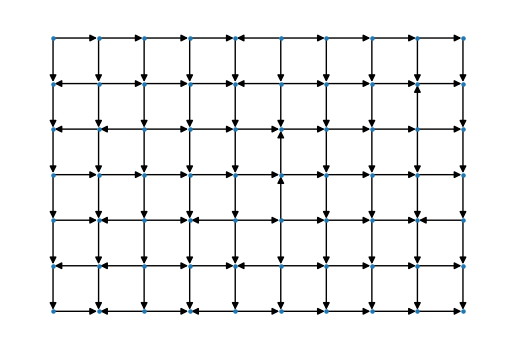

In [15]:
def random_grid(n, m, px, py):
    G = nx.DiGraph()
    for i in range(m):
        for j in range(n):
            G.add_node((i,j))
            G.nodes[(i,j)]['x'] = i
            G.nodes[(i,j)]['y'] = j

    for (i,j) in G:
        if i<m-1:
            if np.random.random() < px:
                G.add_edge((i,j), (i+1,j), length=1)
            else:
                G.add_edge((i+1,j), (i,j), length=1)
        if j<n-1:
            if np.random.random() < py:# or len(list(G.successors((i,j))))==0:
                G.add_edge((i,j), (i,j+1), length=1)
            else:
                G.add_edge((i,j+1), (i,j), length=1)
    return G

draw_graph(random_grid(7,10,0.8, 0.1))


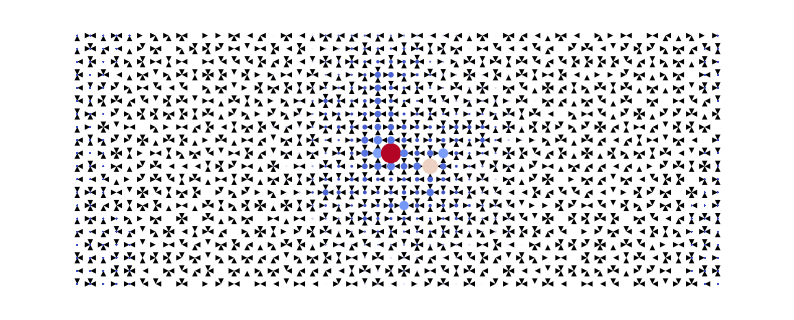

In [16]:
n = 20
m = 50
G = random_grid(n,m,.5, .5)
G = relabel_nodes(G)
G_undirected = G.copy().to_undirected()

A = gradient(G, type=4)
L = laplacian(G_undirected)

t = 10
ft = np.zeros(len(G))
ft[int(n/2*m+n/2)] = 1
ft  = expm(-t*(A+0.1*L)) @ ft

plt.figure(figsize=(10,5))
draw_graph(G, node_color=ft, width=0, node_size=1000*ft, cmap='coolwarm')

# Real world examples

### Strade di Pisa

In [17]:
# download street network data from OSM and construct a MultiDiGraph model
# street_map = ox.graph_from_place("Pisa, Italy", network_type="drive")
street_map = ox.graph_from_point((43.715049, 10.396794), dist=5000, network_type="drive")

# impute edge (driving) speeds and calculate edge traversal times
street_map = ox.add_edge_speeds(street_map)
street_map = ox.add_edge_travel_times(street_map)

# you can convert MultiDiGraph to/from geopandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(street_map)
street_map = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=street_map.graph)
street_map, labels = relabel_nodes(street_map, return_labels=True)

# convert MultiDiGraph to DiGraph to use nx.betweenness_centrality function
# choose between parallel edges by minimizing travel_time attribute value
G = ox.utils_graph.get_digraph(street_map, weight="travel_time").to_undirected()

# # calculate node betweenness centrality, weighted by travel time
# bc = nx.betweenness_centrality(D, weight="travel_time", normalized=True)
# nx.set_node_attributes(G, values=bc, name="bc")

for u in G:
    G.nodes[u]['pos'] = (G.nodes[u]['x'], G.nodes[u]['y'])

G.remove_edges_from(nx.selfloop_edges(G))

for u, v, data in G.edges(data=True):
    data["length"] = data.pop("travel_time")

J = G.copy().to_directed()
J.remove_edges_from(list(J.edges))

target = labels[242960519]
lengths = nx.shortest_path_length(G, target=target, weight='length')
D = np.zeros((len(G), len(G)))
for u in G:
    if u != target:
        best_directions = sorted(G.neighbors(u), key = lambda v: lengths[v])[0:1]
        for v in best_directions:
            J.add_edge(u,v, length = G.edges[(u,v)]['length'])

# draw_graph(G, node_size=.2, with_labels = False)

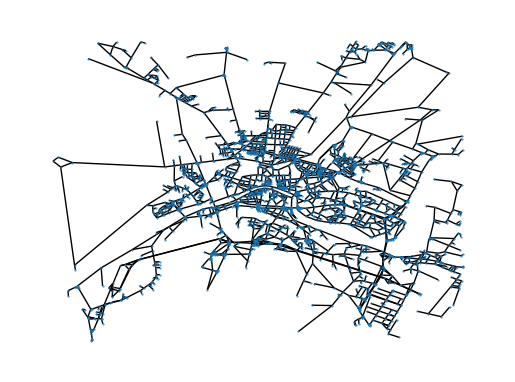

In [18]:
draw_graph(G, node_size=.2, with_labels = False)

In [19]:
A = gradient(J)
L = laplacian(G)

eM = expm(-100*A)
# eM = expm(-100*(A+0.5*L))

Consideriamo il tragitto tra Ospedaletto e Via di Gello. Osserviamo che il traffico si divide in due strade, una delle due apparentemente più trafficata: noto però che nella seconda i nodi sono meno densi, ed è quindi naturale che trattengano più massa.

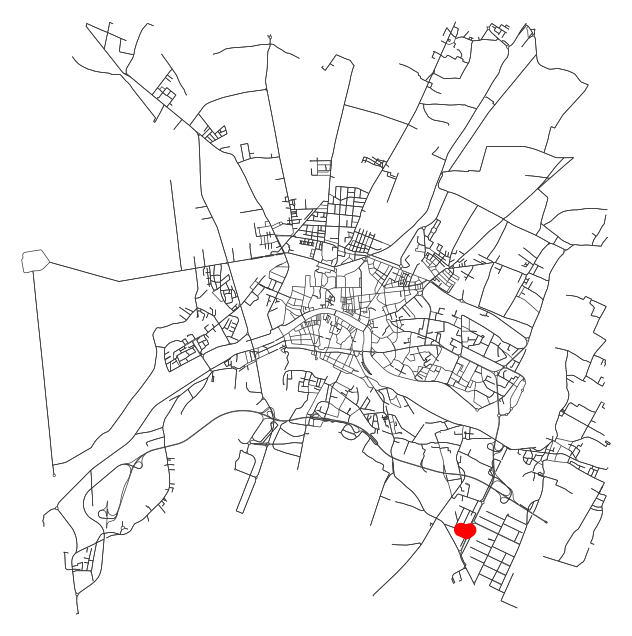

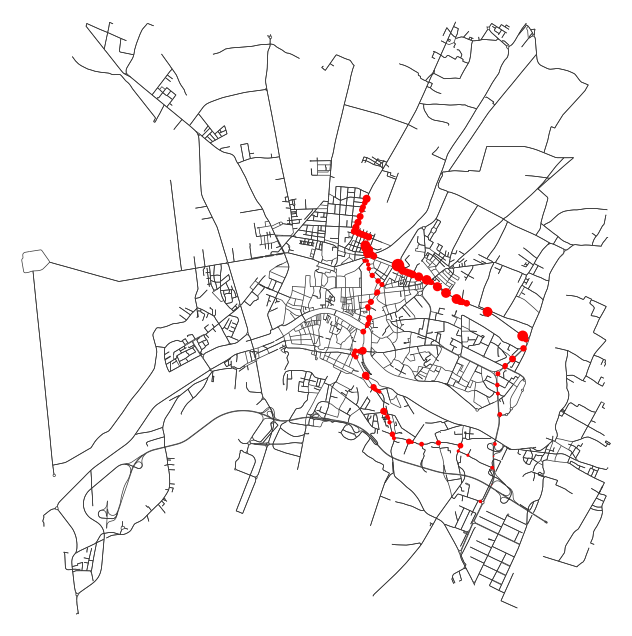

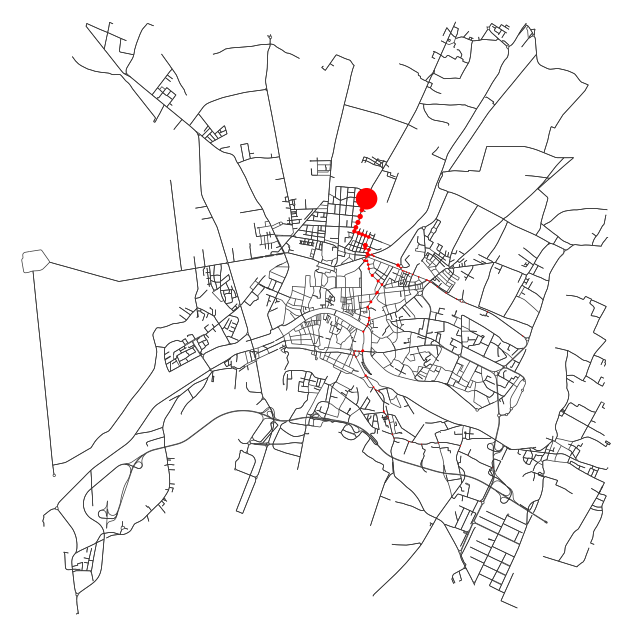

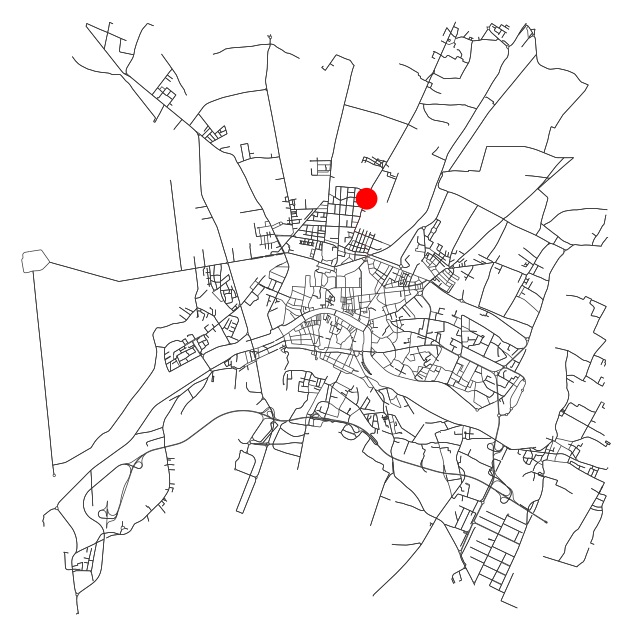

In [20]:
ft = np.zeros(len(G))

cascina = ox.graph_from_point((43.683643796307756, 10.42889794443604), dist=100, network_type="drive")

for u in cascina.nodes:
    ft[labels[u]] = 1

for i in range(4):

    f_dict = dict(enumerate(ft))
    nx.set_node_attributes(street_map, values=f_dict, name="f")

    nc = ox.plot.get_node_colors_by_attr(street_map, "f", cmap="coolwarm")

    fig, ax = ox.plot_graph(
        street_map, bgcolor="w", node_color='r', node_size=100*ft**(0.5), edge_linewidth=.5, edge_color="#333333",
        # show=False, save=True, filepath=filename,
    )
    fig.suptitle(f't={400*i}')
    plt.show()

    ft = eM @ eM @ eM @ eM @ ft



Vediamo cosa succede evidenziando il traffico su ciascun arco $(u,v)$ come $\sqrt{f(u)f(v)}$ rinormalizzato per la lunghezza dell'arco:

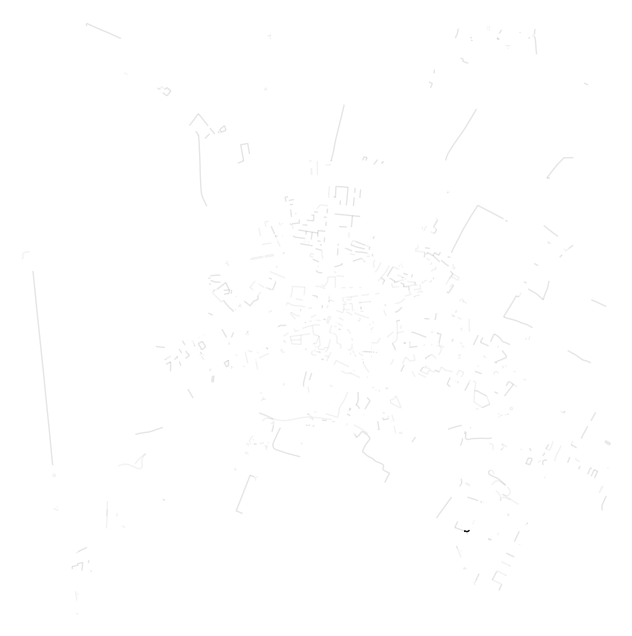

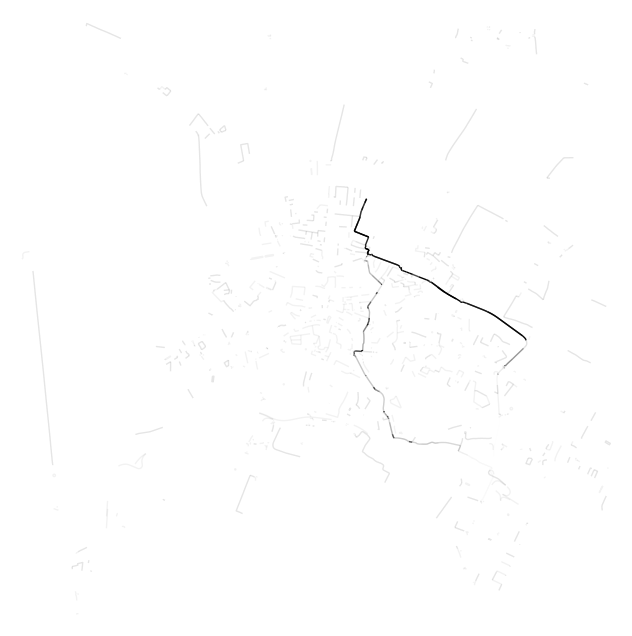

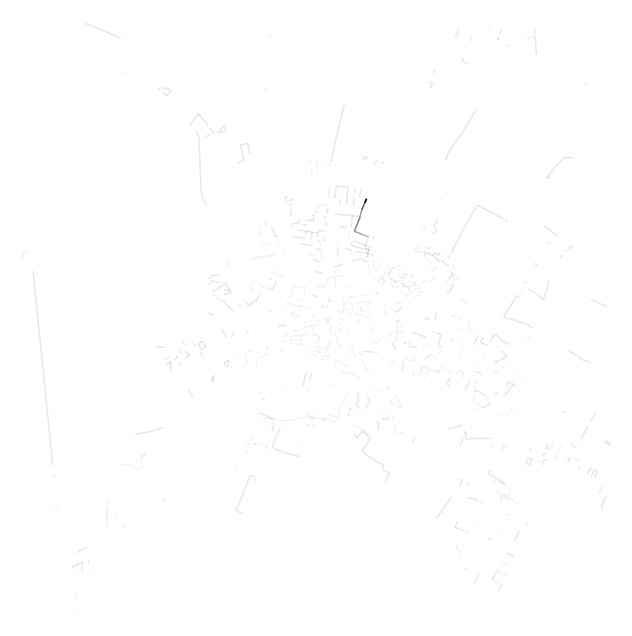

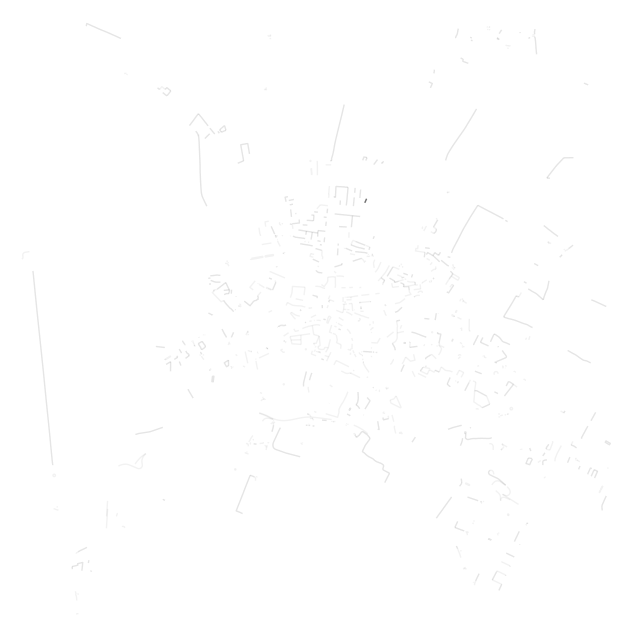

In [21]:
ft = np.zeros(len(G))

cascina = ox.graph_from_point((43.683643796307756, 10.42889794443604), dist=100, network_type="drive")

for u in cascina.nodes:
    ft[labels[u]] = 1

def normalization(z):
    return (1/(1 + np.exp(-z))-1/2)*2

for i in range(4):

    edge_widths = []
    for (u,v,_) in street_map.edges:
        if (u,v) in J.edges:
            edge_widths.append(300*np.sqrt(ft[u]*ft[v])/J.edges[(u,v)]['length'])
        elif (v,u) in J.edges:
            edge_widths.append(300*np.sqrt(ft[u]*ft[v])/J.edges[(v,u)]['length'])
        else:
            edge_widths.append(0.1)

    fig, ax = ox.plot_graph(
        street_map, bgcolor="w", node_color='w', node_size=0,
            edge_alpha = [normalization(w) for w in edge_widths],
            edge_color='black',
        # show=False, save=True, filepath=filename,
    )

    fig.suptitle(f't={400*i}')
    plt.show()

    ft = eM @ eM @ eM @ eM @ ft

# print(G.edges)

# print(J.nodes)


# Altri esempi [da ricontrollare]

Qualche esperimento su _advection-diffusion_ sulla metro di Londra.

In [22]:
G = nx.Graph()

with open('london_tube_nodes.txt', 'r') as nodes_file:
    for line in nodes_file:
        node_id, label, x, y = line.strip().split()
        G.add_node(node_id, label=label, x=float(x), y=float(y))

with open('london_tube_edges.txt', 'r') as edges_file:
    next(edges_file)
    for line in edges_file:
        layer_id, node_id1, node_id2, edge_weight = line.strip().split()
        G.add_edge(node_id1, node_id2, layer_id=layer_id, weight=float(edge_weight))

G = relabel_nodes(G)

for (u,v) in G.edges:
    xu, yu = G.nodes[u]['x'], G.nodes[u]['y']
    xv, yv = G.nodes[v]['x'], G.nodes[v]['y']
    G.edges[u,v]['length'] = np.sqrt((xu-xv)**2+(yv-yv)**2)

pos = {node: (G.nodes[node]['x'], G.nodes[node]['y']) for node in G.nodes}
labels = {node: G.nodes[node]['label'] for node in G.nodes}
# plt.figure(figsize=(35,35))
# nx.draw(G, with_labels=True, pos=pos, font_size = 16, node_size=1000, node_color='w')
# plt.show()

### Tragitto da un punto opposto all'altro

Consideriamo una massa concentrata su un nodo _source_ e un'orientazione $J$ che collega ogni nodo con il suo vicino più prossimo a un nodo _target_. Osserviamo che la massa si trasferisce più velocemente quando c'è meno diffusione.

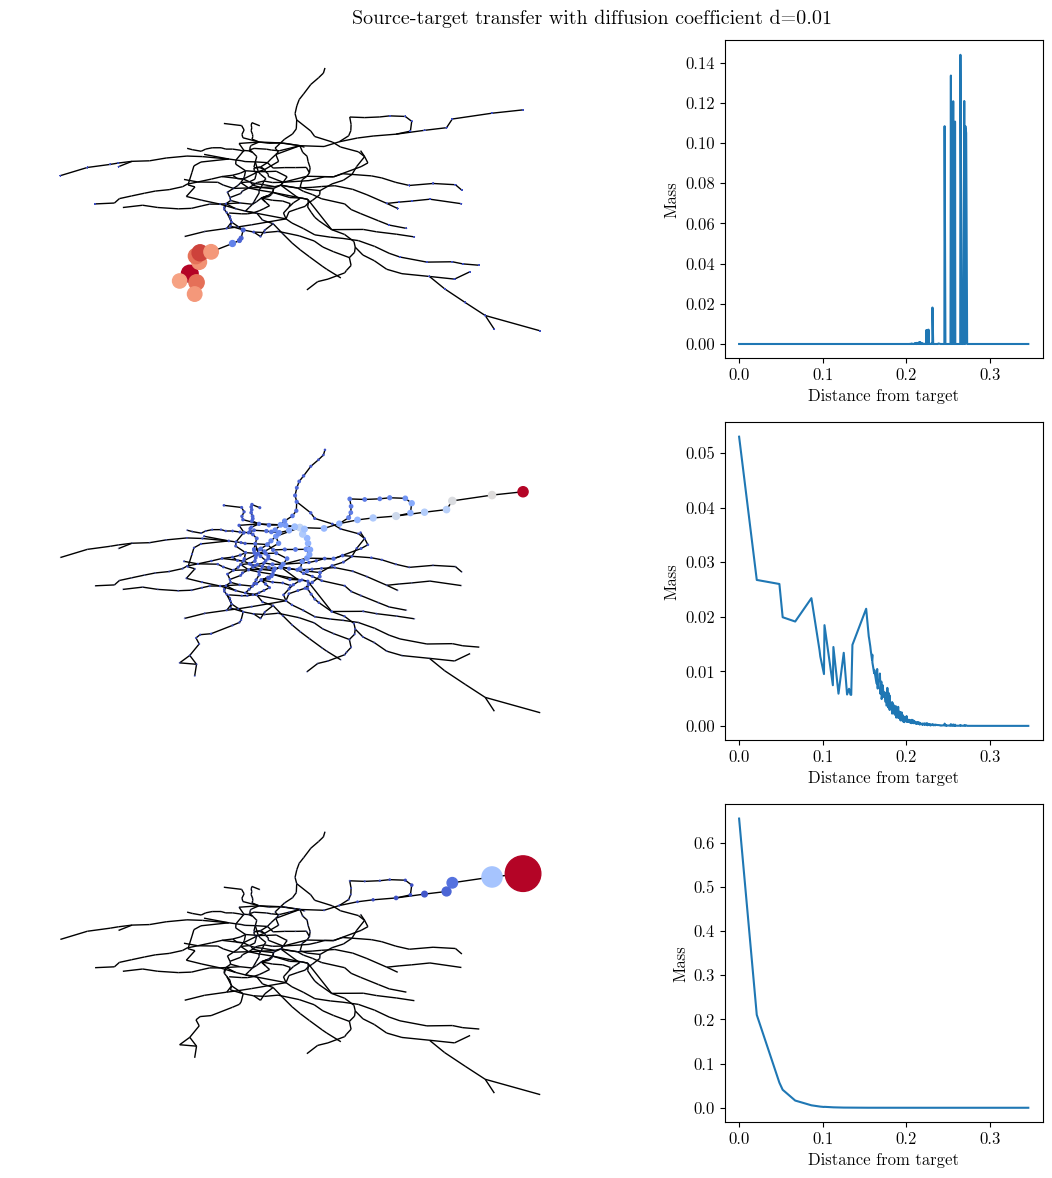

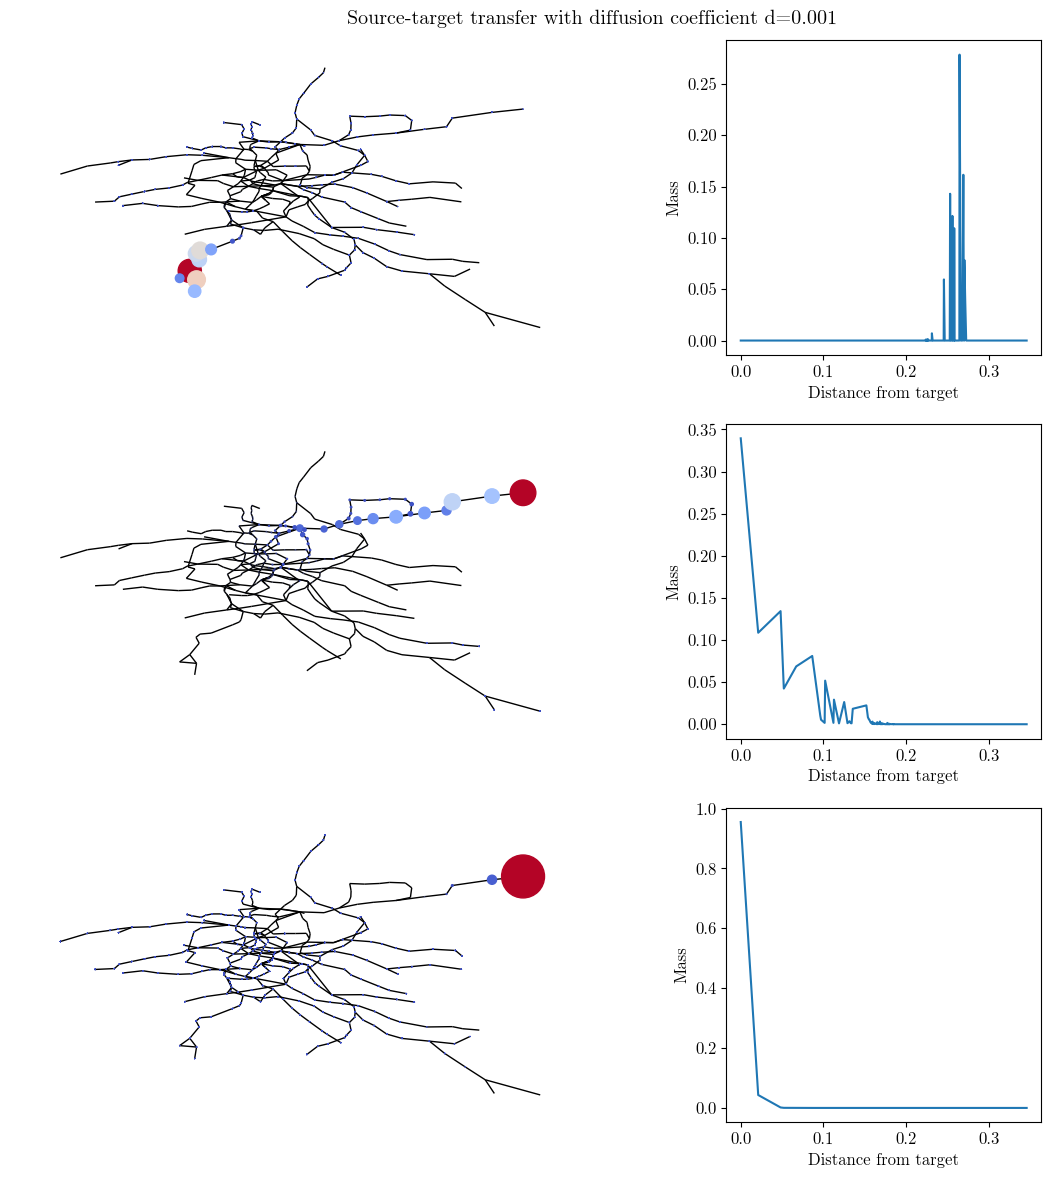

In [23]:
target = 357
source = 238

J = G.copy().to_directed()
J.remove_edges_from(list(J.edges))

distances = nx.shortest_path_length(G, target=target, weight='length')
for u in G:
    if u != target:
        best_direction = sorted(G.neighbors(u), key = lambda v: distances[v])[0]
        J.add_edge(u,best_direction, length = G.edges[(u,best_direction)]['length'])
    else:
        J.add_edge(u,u, length = 1)

# plt.figure(figsize=(35,35))
# nx.draw(J, with_labels=True, pos=pos, font_size = 16, node_size=1000, node_color='w')

L = laplacian(G)
D = gradient(J, type=4)

for d in [0.01, 0.001]:

    fig, ax = plt.subplots(3, 2, figsize=(12,12))
    plt.suptitle(f'Source-target transfer with diffusion coefficient d={d}')
    for i,t in enumerate([0.01, 0.3, 10]):
        ft = np.zeros(len(G))
        ft[source] = 1
        ft = expm(-t*(d*L+D)) @ ft
        distribution = [y[1] for y in sorted(enumerate(list(ft)), key=lambda x: distances[x[0]])]

        nx.draw(G, ax=ax[i,0], with_labels=False, pos=pos, font_size = 6, node_color=ft, cmap='coolwarm', node_size=ft*1000)
        ax[i,1].plot(sorted(distances.values()), distribution)
        ax[i,1].set_xlabel('Distance from target')
        ax[i,1].set_ylabel('Mass')
        ax[i,1].set_box_aspect(1)    
    plt.tight_layout()


### Fuga da un punto

Consideriamo ora massa concentrata su un nodo centrale e un'orientazione $J$ che porta la massa a ``fuggire'' da tale nodo, costruita invertendo l'orientazione verso il nodo centrale. Il grafico ora rappresenta la distribuzione di massa a un tempo $t$ fissato. Osserviamo che per valori piccoli di diffusione, aggiungere diffusione aiuta i nodi ad allontanarsi più rapidamente dal nodo centrale (a parte nel caso di tempi grandi e diffusione grande). [Da capire questo comportamento, e da controllare che non sia dovuto a qualche questione tecnica su come si definisce l'orientazione.]

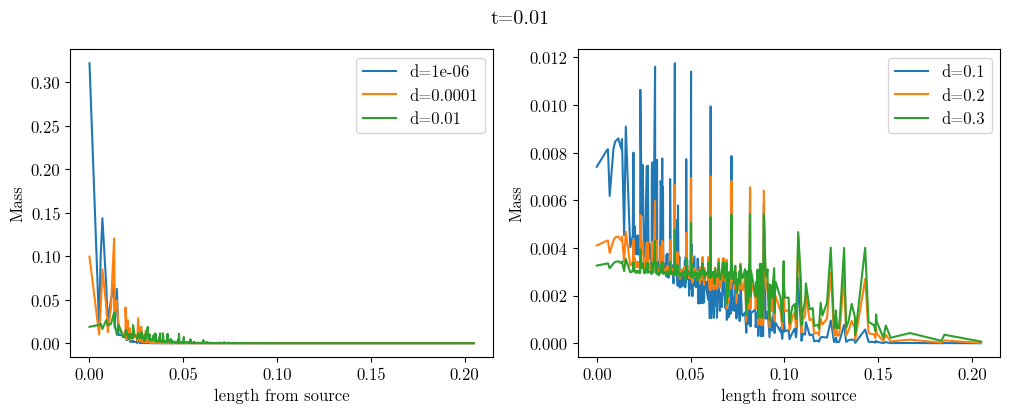

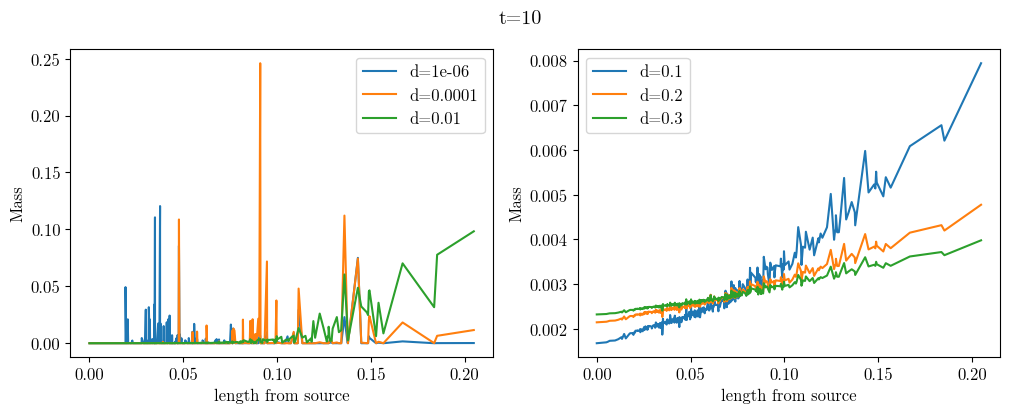

In [24]:
source = 268

J = G.copy().to_directed()
J.remove_edges_from(list(J.edges))

lengths = nx.shortest_path_length(G, target=source, weight='length')
for u in G:
    if u != source:
        best_direction = sorted(G.neighbors(u), key = lambda v: lengths[v])[0]
        J.add_edge(u,best_direction, length = G.edges[(u,best_direction)]['length'])
    else:
        J.add_edge(u,u, length = 1)

J = J.reverse()

for u in J:
    if J.out_degree(u) == 0:
        J.add_edge(u,u, length = 1)

ft = np.zeros(len(G))
ft[source] = 1

L = laplacian(G)
D = gradient(J)


for t in [0.01, 10]:
    fig, ax = plt.subplots(1, 2, figsize=(12,4))
    fig.suptitle(f't={t}')
    ft = np.zeros(len(G))
    ft[source] = 1
    for d in [0.000001, 0.0001, 0.01]:
        ft = expm(-t*(d*L+D)) @ ft

        distribution = [y[1] for y in sorted(enumerate(list(ft)), key=lambda x: lengths[x[0]])]

        ax[0].plot(sorted(lengths.values()), distribution, label=f'd={d}')
    ax[0].legend()
    ax[0].set_xlabel('length from source')
    ax[0].set_ylabel('Mass')

    for d in [0.1, 0.2, 0.3]: 
        ft = np.zeros(len(G))
        ft[source] = 1
        ft = expm(-t*(d*L+D)) @ ft

        distribution = [y[1] for y in sorted(enumerate(list(ft)), key=lambda x: lengths[x[0]])]

        ax[1].plot(sorted(lengths.values()), distribution, label=f'd={d}')
    ax[1].legend()
    ax[1].set_xlabel('length from source')
    ax[1].set_ylabel('Mass')

# plt.figure(figsize=(15,15))
# nx.draw(G, with_labels=False, pos=pos, font_size = 6, node_color=ft, cmap='coolwarm', node_size=ft*3000)
plt.show()
